# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   level   1206 non-null   int64 
 1   con     1206 non-null   int64 
 2   ac      1206 non-null   int64 
 3   str     1206 non-null   int64 
 4   book    1206 non-null   object
 5   wis     1206 non-null   int64 
 6   int     1206 non-null   int64 
 7   cha     1206 non-null   int64 
 8   dex     1206 non-null   int64 
 9   hp      1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,level,con,ac,str,book,wis,int,cha,dex,hp
0,10,5,29,7,Pathfinder Bestiary,2,1,1,2,215
1,10,5,28,9,Pathfinder Bestiary,2,-4,1,0,220
2,8,6,25,7,Pathfinder Bestiary,3,-4,-2,3,175
3,17,5,41,7,Pathfinder Bestiary,5,6,6,4,315
4,1,1,16,-5,Pathfinder Bestiary,1,-1,1,3,20


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


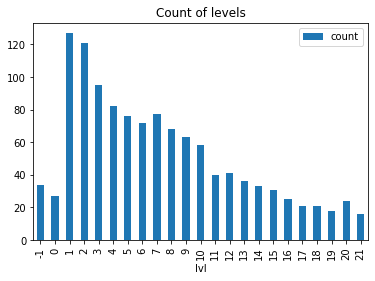

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.67
MAE: 0.47


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

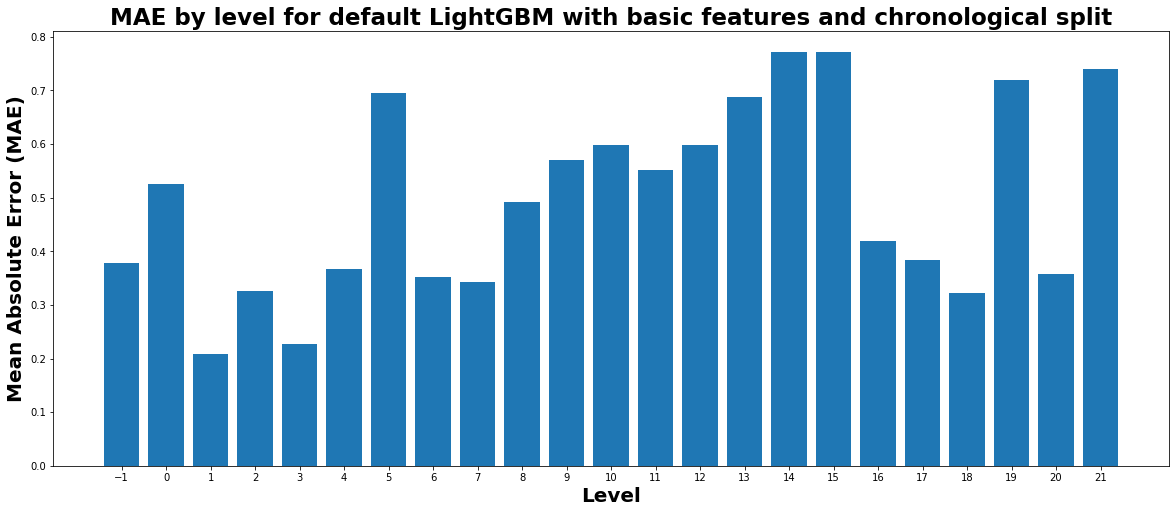

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.67

Round type: 0.5
RMSE: 0.71

Round type: 0.33
RMSE: 0.71

Round type: 0.45
RMSE: 0.70



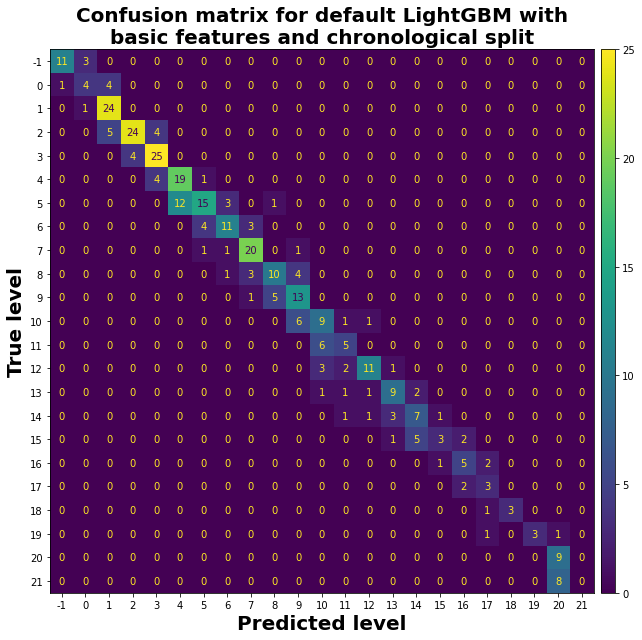

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with\nbasic features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-09 13:19:21,194] A new study created in memory with name: no-name-7cb0f8de-2edf-4432-b0be-ee3dedc89198
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.234102 + 0.0514901
[200]	cv_agg's l2: 0.232555 + 0.0496004


feature_fraction, val_score: 0.231230:  14%|######4                                      | 1/7 [00:01<00:06,  1.15s/it]

Early stopping, best iteration is:
[174]	cv_agg's l2: 0.23123 + 0.0496955
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514


feature_fraction, val_score: 0.224032:  14%|######4                                      | 1/7 [00:02<00:06,  1.15s/it]

[400]	cv_agg's l2: 0.225133 + 0.0394947
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976


feature_fraction, val_score: 0.224032:  29%|############8                                | 2/7 [00:02<00:07,  1.53s/it]

[100]	cv_agg's l2: 0.319162 + 0.0766611
[200]	cv_agg's l2: 0.283683 + 0.0737265
[300]	cv_agg's l2: 0.271895 + 0.0722703


feature_fraction, val_score: 0.224032:  29%|############8                                | 2/7 [00:04<00:07,  1.53s/it]

[400]	cv_agg's l2: 0.267297 + 0.0704172
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976


feature_fraction, val_score: 0.224032:  43%|###################2                         | 3/7 [00:04<00:06,  1.53s/it]

[100]	cv_agg's l2: 0.334841 + 0.0479463
[200]	cv_agg's l2: 0.289758 + 0.0474872
[300]	cv_agg's l2: 0.277413 + 0.0471921


feature_fraction, val_score: 0.224032:  57%|#########################7                   | 4/7 [00:06<00:04,  1.62s/it]

[400]	cv_agg's l2: 0.272518 + 0.0468105
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514


feature_fraction, val_score: 0.224032:  71%|################################1            | 5/7 [00:07<00:03,  1.61s/it]

[400]	cv_agg's l2: 0.225133 + 0.0394947
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976
[100]	cv_agg's l2: 0.272153 + 0.0659505
[200]	cv_agg's l2: 0.253752 + 0.0642911
[300]	cv_agg's l2: 0.249112 + 0.0630054


feature_fraction, val_score: 0.224032:  86%|######################################5      | 6/7 [00:09<00:01,  1.60s/it]

[400]	cv_agg's l2: 0.249275 + 0.0625293
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976
[100]	cv_agg's l2: 0.231219 + 0.0486198
[200]	cv_agg's l2: 0.228528 + 0.0485772
[300]	cv_agg's l2: 0.230363 + 0.0485634
[400]	cv_agg's l2: 0.232343 + 0.0493364


feature_fraction, val_score: 0.224032: 100%|#############################################| 7/7 [00:12<00:00,  1.71s/it]


Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976


num_leaves, val_score: 0.224032:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947


num_leaves, val_score: 0.224032:   5%|##5                                               | 1/20 [00:03<01:02,  3.28s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947


num_leaves, val_score: 0.224032:  10%|#####                                             | 2/20 [00:06<00:54,  3.04s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947


num_leaves, val_score: 0.224032:  15%|#######5                                          | 3/20 [00:09<00:51,  3.05s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947


num_leaves, val_score: 0.224032:  20%|##########                                        | 4/20 [00:12<00:49,  3.09s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.224032 + 0.0386976
[100]	cv_agg's l2: 0.235852 + 0.0373545
[200]	cv_agg's l2: 0.223141 + 0.0354937
[300]	cv_agg's l2: 0.219912 + 0.0339794
[400]	cv_agg's l2: 0.217359 + 0.0313949


num_leaves, val_score: 0.216390:  25%|############5                                     | 5/20 [00:13<00:36,  2.45s/it]

[500]	cv_agg's l2: 0.217064 + 0.0298628
Early stopping, best iteration is:
[455]	cv_agg's l2: 0.21639 + 0.0299279
[100]	cv_agg's l2: 0.241615 + 0.0416734
[200]	cv_agg's l2: 0.227025 + 0.0407864
[300]	cv_agg's l2: 0.222554 + 0.0378673
[400]	cv_agg's l2: 0.219824 + 0.0359901
[500]	cv_agg's l2: 0.216988 + 0.0356074
[600]	cv_agg's l2: 0.215901 + 0.0338679
[700]	cv_agg's l2: 0.214468 + 0.0324025
[800]	cv_agg's l2: 0.214038 + 0.0308942
[900]	cv_agg's l2: 0.212611 + 0.0309677
[1000]	cv_agg's l2: 0.211318 + 0.0301444
[1100]	cv_agg's l2: 0.210616 + 0.029592
[1200]	cv_agg's l2: 0.210326 + 0.0291483


num_leaves, val_score: 0.210110:  30%|###############                                   | 6/20 [00:16<00:33,  2.41s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.241615 + 0.0416734
[200]	cv_agg's l2: 0.227025 + 0.0407864
[300]	cv_agg's l2: 0.222554 + 0.0378673
[400]	cv_agg's l2: 0.219824 + 0.0359901
[500]	cv_agg's l2: 0.216988 + 0.0356074
[600]	cv_agg's l2: 0.215901 + 0.0338679
[700]	cv_agg's l2: 0.214468 + 0.0324025
[800]	cv_agg's l2: 0.214038 + 0.0308942
[900]	cv_agg's l2: 0.212611 + 0.0309677
[1000]	cv_agg's l2: 0.211318 + 0.0301444
[1100]	cv_agg's l2: 0.210616 + 0.029592
[1200]	cv_agg's l2: 0.210326 + 0.0291483


num_leaves, val_score: 0.210110:  35%|#################5                                | 7/20 [00:18<00:30,  2.36s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.241615 + 0.0416734
[200]	cv_agg's l2: 0.227025 + 0.0407864
[300]	cv_agg's l2: 0.222554 + 0.0378673
[400]	cv_agg's l2: 0.219824 + 0.0359901
[500]	cv_agg's l2: 0.216988 + 0.0356074
[600]	cv_agg's l2: 0.215901 + 0.0338679
[700]	cv_agg's l2: 0.214468 + 0.0324025
[800]	cv_agg's l2: 0.214038 + 0.0308942
[900]	cv_agg's l2: 0.212611 + 0.0309677
[1000]	cv_agg's l2: 0.211318 + 0.0301444
[1100]	cv_agg's l2: 0.210616 + 0.029592


num_leaves, val_score: 0.210110:  40%|####################                              | 8/20 [00:20<00:28,  2.41s/it]

[1200]	cv_agg's l2: 0.210326 + 0.0291483
Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110:  45%|######################5                           | 9/20 [00:31<00:56,  5.11s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110:  50%|########################5                        | 10/20 [00:45<01:17,  7.75s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.353035 + 0.0659078
[200]	cv_agg's l2: 0.312899 + 0.0642578
[300]	cv_agg's l2: 0.301933 + 0.0645596
[400]	cv_agg's l2: 0.299229 + 0.0647634
[500]	cv_agg's l2: 0.296951 + 0.0649927
[600]	cv_agg's l2: 0.295586 + 0.0654638
[700]	cv_agg's l2: 0.29475 + 0.0652585
[800]	cv_agg's l2: 0.293671 + 0.0651303
[900]	cv_agg's l2: 0.292873 + 0.0646998
[1000]	cv_agg's l2: 0.292041 + 0.0644776
[1100]	cv_agg's l2: 0.291459 + 0.0641247


num_leaves, val_score: 0.210110:  55%|##########################9                      | 11/20 [00:47<00:53,  5.93s/it]

[1200]	cv_agg's l2: 0.290597 + 0.0636897
Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110:  60%|#############################4                   | 12/20 [01:00<01:04,  8.11s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110:  65%|###############################8                 | 13/20 [01:14<01:10, 10.05s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110:  70%|##################################3              | 14/20 [01:31<01:11, 11.98s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.241615 + 0.0416734
[200]	cv_agg's l2: 0.227025 + 0.0407864
[300]	cv_agg's l2: 0.222554 + 0.0378673
[400]	cv_agg's l2: 0.219824 + 0.0359901
[500]	cv_agg's l2: 0.216988 + 0.0356074
[600]	cv_agg's l2: 0.215901 + 0.0338679
[700]	cv_agg's l2: 0.214468 + 0.0324025
[800]	cv_agg's l2: 0.214038 + 0.0308942
[900]	cv_agg's l2: 0.212611 + 0.0309677
[1000]	cv_agg's l2: 0.211318 + 0.0301444
[1100]	cv_agg's l2: 0.210616 + 0.029592


num_leaves, val_score: 0.210110:  75%|####################################7            | 15/20 [01:35<00:48,  9.67s/it]

[1200]	cv_agg's l2: 0.210326 + 0.0291483
Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110:  80%|#######################################2         | 16/20 [01:53<00:48, 12.16s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110:  85%|#########################################6       | 17/20 [02:12<00:42, 14.25s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110:  90%|############################################1    | 18/20 [02:29<00:29, 14.90s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.231042 + 0.0390821
[200]	cv_agg's l2: 0.224912 + 0.0413987
[300]	cv_agg's l2: 0.223046 + 0.040736
[400]	cv_agg's l2: 0.223302 + 0.041425
[500]	cv_agg's l2: 0.224002 + 0.0416891
[600]	cv_agg's l2: 0.225403 + 0.0426484
[700]	cv_agg's l2: 0.228034 + 0.0427027
[800]	cv_agg's l2: 0.22939 + 0.0429864
[900]	cv_agg's l2: 0.23076 + 0.0429391
[1000]	cv_agg's l2: 0.231935 + 0.0426042
[1100]	cv_agg's l2: 0.233204 + 0.0425809
[1200]	cv_agg's l2: 0.2342 + 0.0425827


num_leaves, val_score: 0.210110:  95%|##############################################5  | 19/20 [02:43<00:14, 14.73s/it]

Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.234682 + 0.0338797
[200]	cv_agg's l2: 0.226131 + 0.037056
[300]	cv_agg's l2: 0.22466 + 0.0382514
[400]	cv_agg's l2: 0.225133 + 0.0394947
[500]	cv_agg's l2: 0.226234 + 0.0403387
[600]	cv_agg's l2: 0.228207 + 0.0406027
[700]	cv_agg's l2: 0.229374 + 0.0403837
[800]	cv_agg's l2: 0.230701 + 0.040343
[900]	cv_agg's l2: 0.232112 + 0.0400878
[1000]	cv_agg's l2: 0.233124 + 0.040323
[1100]	cv_agg's l2: 0.234181 + 0.0403605
[1200]	cv_agg's l2: 0.235212 + 0.0399222


num_leaves, val_score: 0.210110: 100%|#################################################| 20/20 [02:58<00:00,  8.93s/it]


Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678


bagging, val_score: 0.210110:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.286168 + 0.0639086
[200]	cv_agg's l2: 0.268136 + 0.0621633
[300]	cv_agg's l2: 0.258317 + 0.0632051
[400]	cv_agg's l2: 0.25146 + 0.0622954
[500]	cv_agg's l2: 0.246984 + 0.0590986
[600]	cv_agg's l2: 0.24242 + 0.0582752
[700]	cv_agg's l2: 0.23954 + 0.0556529
[800]	cv_agg's l2: 0.237091 + 0.0568881
[900]	cv_agg's l2: 0.23449 + 0.0533583
[1000]	cv_agg's l2: 0.233116 + 0.0513873
[1100]	cv_agg's l2: 0.229191 + 0.050116


bagging, val_score: 0.210110:  10%|#####3                                               | 1/10 [00:04<00:44,  4.92s/it]

[1200]	cv_agg's l2: 0.227735 + 0.0508494
Early stopping, best iteration is:
[1123]	cv_agg's l2: 0.21011 + 0.0294678
[100]	cv_agg's l2: 0.241304 + 0.0393725
[200]	cv_agg's l2: 0.228468 + 0.0369545
[300]	cv_agg's l2: 0.22334 + 0.0334066
[400]	cv_agg's l2: 0.217777 + 0.0323272
[500]	cv_agg's l2: 0.215276 + 0.0311436
[600]	cv_agg's l2: 0.213183 + 0.0308191
[700]	cv_agg's l2: 0.21156 + 0.0308411
[800]	cv_agg's l2: 0.210383 + 0.0312574


bagging, val_score: 0.209859:  20%|##########6                                          | 2/10 [00:09<00:35,  4.48s/it]

[900]	cv_agg's l2: 0.210817 + 0.0317373
Early stopping, best iteration is:
[819]	cv_agg's l2: 0.209859 + 0.03091
[100]	cv_agg's l2: 0.242868 + 0.0390811
[200]	cv_agg's l2: 0.228137 + 0.0389859
[300]	cv_agg's l2: 0.22389 + 0.036405
[400]	cv_agg's l2: 0.219292 + 0.0351033
[500]	cv_agg's l2: 0.216725 + 0.0344288
[600]	cv_agg's l2: 0.215307 + 0.0330946
[700]	cv_agg's l2: 0.214743 + 0.0331299
[800]	cv_agg's l2: 0.212526 + 0.0342828


bagging, val_score: 0.209859:  30%|###############9                                     | 3/10 [00:12<00:28,  4.05s/it]

[900]	cv_agg's l2: 0.211627 + 0.0342979
Early stopping, best iteration is:
[819]	cv_agg's l2: 0.209859 + 0.03091
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


bagging, val_score: 0.208017:  40%|#####################2                               | 4/10 [00:18<00:28,  4.75s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337
[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318


bagging, val_score: 0.208017:  50%|##########################5                          | 5/10 [00:24<00:26,  5.24s/it]

[100]	cv_agg's l2: 0.241615 + 0.0416734
[200]	cv_agg's l2: 0.227025 + 0.0407864
[300]	cv_agg's l2: 0.222554 + 0.0378673
[400]	cv_agg's l2: 0.219824 + 0.0359901
[500]	cv_agg's l2: 0.216988 + 0.0356074
[600]	cv_agg's l2: 0.215901 + 0.0338679
[700]	cv_agg's l2: 0.214468 + 0.0324025
[800]	cv_agg's l2: 0.214038 + 0.0308942
[900]	cv_agg's l2: 0.212611 + 0.0309677
[1000]	cv_agg's l2: 0.211318 + 0.0301444
[1100]	cv_agg's l2: 0.210616 + 0.029592


bagging, val_score: 0.208017:  60%|###############################8                     | 6/10 [00:30<00:21,  5.33s/it]

[1200]	cv_agg's l2: 0.210326 + 0.0291483
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.242513 + 0.0365212
[200]	cv_agg's l2: 0.229222 + 0.0395971
[300]	cv_agg's l2: 0.225092 + 0.0376531
[400]	cv_agg's l2: 0.221683 + 0.0355058
[500]	cv_agg's l2: 0.217423 + 0.0338062
[600]	cv_agg's l2: 0.215261 + 0.0330718
[700]	cv_agg's l2: 0.215382 + 0.0327614
[800]	cv_agg's l2: 0.214249 + 0.0329702
[900]	cv_agg's l2: 0.213485 + 0.0333055
[1000]	cv_agg's l2: 0.213401 + 0.032172
[1100]	cv_agg's l2: 0.213368 + 0.0318839
[1200]	cv_agg's l2: 0.212946 + 0.0316198


bagging, val_score: 0.208017:  70%|#####################################                | 7/10 [00:34<00:15,  5.19s/it]

Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.259572 + 0.0453072
[200]	cv_agg's l2: 0.245133 + 0.0432165
[300]	cv_agg's l2: 0.2383 + 0.0422056
[400]	cv_agg's l2: 0.232682 + 0.0402238
[500]	cv_agg's l2: 0.23154 + 0.0396956
[600]	cv_agg's l2: 0.228565 + 0.0394341
[700]	cv_agg's l2: 0.225963 + 0.0373953
[800]	cv_agg's l2: 0.223674 + 0.0364363
[900]	cv_agg's l2: 0.222948 + 0.0351616
[1000]	cv_agg's l2: 0.220989 + 0.0345445
[1100]	cv_agg's l2: 0.220511 + 0.0328079
[1200]	cv_agg's l2: 0.219824 + 0.0326235


bagging, val_score: 0.208017:  80%|##########################################4          | 8/10 [00:41<00:11,  5.76s/it]

Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.335096 + 0.0862621
[200]	cv_agg's l2: 0.310533 + 0.0713054
[300]	cv_agg's l2: 0.306739 + 0.074096
[400]	cv_agg's l2: 0.293703 + 0.073405
[500]	cv_agg's l2: 0.287848 + 0.0667676
[600]	cv_agg's l2: 0.289404 + 0.0701356
[700]	cv_agg's l2: 0.280426 + 0.0667252
[800]	cv_agg's l2: 0.277061 + 0.0680986
[900]	cv_agg's l2: 0.273515 + 0.0605463
[1000]	cv_agg's l2: 0.270324 + 0.0667781
[1100]	cv_agg's l2: 0.274039 + 0.0604727


bagging, val_score: 0.208017:  90%|###############################################7     | 9/10 [00:48<00:05,  5.95s/it]

[1200]	cv_agg's l2: 0.270451 + 0.0605626
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.259935 + 0.0475322
[200]	cv_agg's l2: 0.243443 + 0.0455585
[300]	cv_agg's l2: 0.236301 + 0.0425274
[400]	cv_agg's l2: 0.231001 + 0.0388884
[500]	cv_agg's l2: 0.227278 + 0.0358027
[600]	cv_agg's l2: 0.224374 + 0.0350064
[700]	cv_agg's l2: 0.222346 + 0.0344105
[800]	cv_agg's l2: 0.220162 + 0.0346647
[900]	cv_agg's l2: 0.219242 + 0.0328178
[1000]	cv_agg's l2: 0.216981 + 0.0321773
[1100]	cv_agg's l2: 0.216605 + 0.0311081
[1200]	cv_agg's l2: 0.216147 + 0.0311051
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318


feature_fraction_stage2, val_score: 0.208017:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.299876 + 0.0566975
[200]	cv_agg's l2: 0.257708 + 0.052979
[300]	cv_agg's l2: 0.247756 + 0.0500703
[400]	cv_agg's l2: 0.24259 + 0.0459804
[500]	cv_agg's l2: 0.240118 + 0.0433511
[600]	cv_agg's l2: 0.237319 + 0.0411701
[700]	cv_agg's l2: 0.236045 + 0.0404831
[800]	cv_agg's l2: 0.234106 + 0.0395879
[900]	cv_agg's l2: 0.232534 + 0.0383073
[1000]	cv_agg's l2: 0.231787 + 0.037204
[1100]	cv_agg's l2: 0.230765 + 0.036948


feature_fraction_stage2, val_score: 0.208017:  17%|######3                               | 1/6 [00:04<00:21,  4.37s/it]

[1200]	cv_agg's l2: 0.230284 + 0.0357695
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.299876 + 0.0566975
[200]	cv_agg's l2: 0.257708 + 0.052979
[300]	cv_agg's l2: 0.247756 + 0.0500703
[400]	cv_agg's l2: 0.24259 + 0.0459804
[500]	cv_agg's l2: 0.240118 + 0.0433511
[600]	cv_agg's l2: 0.237319 + 0.0411701
[700]	cv_agg's l2: 0.236045 + 0.0404831
[800]	cv_agg's l2: 0.234106 + 0.0395879
[900]	cv_agg's l2: 0.232534 + 0.0383073
[1000]	cv_agg's l2: 0.231787 + 0.037204
[1100]	cv_agg's l2: 0.230765 + 0.036948


feature_fraction_stage2, val_score: 0.208017:  33%|############6                         | 2/6 [00:08<00:17,  4.25s/it]

[1200]	cv_agg's l2: 0.230284 + 0.0357695
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


feature_fraction_stage2, val_score: 0.208017:  50%|###################                   | 3/6 [00:12<00:12,  4.22s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.299876 + 0.0566975
[200]	cv_agg's l2: 0.257708 + 0.052979
[300]	cv_agg's l2: 0.247756 + 0.0500703
[400]	cv_agg's l2: 0.24259 + 0.0459804
[500]	cv_agg's l2: 0.240118 + 0.0433511
[600]	cv_agg's l2: 0.237319 + 0.0411701
[700]	cv_agg's l2: 0.236045 + 0.0404831
[800]	cv_agg's l2: 0.234106 + 0.0395879
[900]	cv_agg's l2: 0.232534 + 0.0383073
[1000]	cv_agg's l2: 0.231787 + 0.037204
[1100]	cv_agg's l2: 0.230765 + 0.036948


feature_fraction_stage2, val_score: 0.208017:  67%|#########################3            | 4/6 [00:16<00:08,  4.23s/it]

[1200]	cv_agg's l2: 0.230284 + 0.0357695
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


feature_fraction_stage2, val_score: 0.208017:  83%|###############################6      | 5/6 [00:22<00:04,  4.79s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


feature_fraction_stage2, val_score: 0.208017: 100%|######################################| 6/6 [00:26<00:00,  4.46s/it]


[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318


regularization_factors, val_score: 0.208017:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.253116 + 0.0439404
[200]	cv_agg's l2: 0.237082 + 0.042042
[300]	cv_agg's l2: 0.229646 + 0.0382327
[400]	cv_agg's l2: 0.224356 + 0.035411
[500]	cv_agg's l2: 0.219528 + 0.033427
[600]	cv_agg's l2: 0.217688 + 0.0319629
[700]	cv_agg's l2: 0.216603 + 0.0313018
[800]	cv_agg's l2: 0.215587 + 0.0303955
[900]	cv_agg's l2: 0.214549 + 0.0302041
[1000]	cv_agg's l2: 0.213453 + 0.0299113
[1100]	cv_agg's l2: 0.212669 + 0.0288395


regularization_factors, val_score: 0.208017:   5%|#9                                    | 1/20 [00:03<01:10,  3.73s/it]

[1200]	cv_agg's l2: 0.212245 + 0.0285047
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.291105 + 0.052848
[200]	cv_agg's l2: 0.286443 + 0.0520987
[300]	cv_agg's l2: 0.286438 + 0.0521028
[400]	cv_agg's l2: 0.286438 + 0.0521028
[500]	cv_agg's l2: 0.286438 + 0.0521028
[600]	cv_agg's l2: 0.286438 + 0.0521028
[700]	cv_agg's l2: 0.286438 + 0.0521028
[800]	cv_agg's l2: 0.286438 + 0.0521028
[900]	cv_agg's l2: 0.286438 + 0.0521028
[1000]	cv_agg's l2: 0.286438 + 0.0521028
[1100]	cv_agg's l2: 0.286438 + 0.0521028


regularization_factors, val_score: 0.208017:  10%|###8                                  | 2/20 [00:05<00:49,  2.74s/it]

[1200]	cv_agg's l2: 0.286438 + 0.0521028
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.0358611
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.211877 + 0.0325084
[600]	cv_agg's l2: 0.210789 + 0.0320956
[700]	cv_agg's l2: 0.21034 + 0.0321113
[800]	cv_agg's l2: 0.20982 + 0.032113
[900]	cv_agg's l2: 0.209452 + 0.0312872
[1000]	cv_agg's l2: 0.209298 + 0.0313227
[1100]	cv_agg's l2: 0.209288 + 0.0313974


regularization_factors, val_score: 0.208017:  15%|#####7                                | 3/20 [00:10<00:58,  3.42s/it]

[1200]	cv_agg's l2: 0.208965 + 0.030914
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.241851 + 0.0424331
[200]	cv_agg's l2: 0.225595 + 0.0406552
[300]	cv_agg's l2: 0.220905 + 0.0395119
[400]	cv_agg's l2: 0.217006 + 0.0374411
[500]	cv_agg's l2: 0.215241 + 0.0361345
[600]	cv_agg's l2: 0.214529 + 0.0354177
[700]	cv_agg's l2: 0.214025 + 0.0342598
[800]	cv_agg's l2: 0.213036 + 0.032961
[900]	cv_agg's l2: 0.213665 + 0.0330528
[1000]	cv_agg's l2: 0.212265 + 0.0323558
[1100]	cv_agg's l2: 0.211774 + 0.0319593


regularization_factors, val_score: 0.208017:  20%|#######6                              | 4/20 [00:14<01:00,  3.78s/it]

[1200]	cv_agg's l2: 0.211551 + 0.0315036
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.252856 + 0.0401468
[200]	cv_agg's l2: 0.238699 + 0.038115
[300]	cv_agg's l2: 0.232842 + 0.0348972
[400]	cv_agg's l2: 0.227581 + 0.0321281
[500]	cv_agg's l2: 0.225496 + 0.029877
[600]	cv_agg's l2: 0.222529 + 0.0293459
[700]	cv_agg's l2: 0.220671 + 0.0289347
[800]	cv_agg's l2: 0.218704 + 0.0282147
[900]	cv_agg's l2: 0.217684 + 0.0277606
[1000]	cv_agg's l2: 0.216873 + 0.027591
[1100]	cv_agg's l2: 0.215912 + 0.0279198


regularization_factors, val_score: 0.208017:  25%|#########5                            | 5/20 [00:18<01:01,  4.09s/it]

[1200]	cv_agg's l2: 0.214413 + 0.0274931
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414521
[200]	cv_agg's l2: 0.223642 + 0.041447
[300]	cv_agg's l2: 0.217843 + 0.0372177
[400]	cv_agg's l2: 0.214288 + 0.0328208
[500]	cv_agg's l2: 0.21165 + 0.032189
[600]	cv_agg's l2: 0.210047 + 0.0310868
[700]	cv_agg's l2: 0.209904 + 0.0315411
[800]	cv_agg's l2: 0.209445 + 0.0316375
[900]	cv_agg's l2: 0.209271 + 0.0310556
[1000]	cv_agg's l2: 0.208806 + 0.0306866
[1100]	cv_agg's l2: 0.208817 + 0.0310244


regularization_factors, val_score: 0.208017:  30%|###########4                          | 6/20 [00:23<00:58,  4.21s/it]

[1200]	cv_agg's l2: 0.208419 + 0.0308594
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.297184 + 0.0510868
[200]	cv_agg's l2: 0.29284 + 0.0512865
[300]	cv_agg's l2: 0.292829 + 0.0512801
[400]	cv_agg's l2: 0.292829 + 0.05128
[500]	cv_agg's l2: 0.292829 + 0.05128
[600]	cv_agg's l2: 0.292829 + 0.05128
[700]	cv_agg's l2: 0.292829 + 0.05128
[800]	cv_agg's l2: 0.292829 + 0.05128
[900]	cv_agg's l2: 0.292829 + 0.05128
[1000]	cv_agg's l2: 0.292829 + 0.05128
[1100]	cv_agg's l2: 0.292829 + 0.05128


regularization_factors, val_score: 0.208017:  35%|#############3                        | 7/20 [00:25<00:46,  3.61s/it]

[1200]	cv_agg's l2: 0.292829 + 0.05128
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.242618 + 0.0398407
[200]	cv_agg's l2: 0.227509 + 0.0392011
[300]	cv_agg's l2: 0.222702 + 0.0357651
[400]	cv_agg's l2: 0.220076 + 0.0330379
[500]	cv_agg's l2: 0.21684 + 0.0317327
[600]	cv_agg's l2: 0.214738 + 0.0298066
[700]	cv_agg's l2: 0.213571 + 0.0292552
[800]	cv_agg's l2: 0.212401 + 0.0279776
[900]	cv_agg's l2: 0.212069 + 0.0281457
[1000]	cv_agg's l2: 0.211096 + 0.0276996
[1100]	cv_agg's l2: 0.210572 + 0.0278926


regularization_factors, val_score: 0.208017:  40%|###############2                      | 8/20 [00:30<00:46,  3.85s/it]

[1200]	cv_agg's l2: 0.209715 + 0.028023
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414521
[200]	cv_agg's l2: 0.223642 + 0.041447
[300]	cv_agg's l2: 0.217843 + 0.0372177
[400]	cv_agg's l2: 0.214288 + 0.0328208
[500]	cv_agg's l2: 0.21165 + 0.032189
[600]	cv_agg's l2: 0.210047 + 0.0310868
[700]	cv_agg's l2: 0.209904 + 0.0315411
[800]	cv_agg's l2: 0.209445 + 0.0316375
[900]	cv_agg's l2: 0.209271 + 0.0310556
[1000]	cv_agg's l2: 0.208806 + 0.0306866
[1100]	cv_agg's l2: 0.208817 + 0.0310244


regularization_factors, val_score: 0.208017:  40%|###############2                      | 8/20 [00:34<00:46,  3.85s/it]

[1200]	cv_agg's l2: 0.208419 + 0.0308595
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318


regularization_factors, val_score: 0.208017:  45%|#################1                    | 9/20 [00:34<00:44,  4.07s/it]

[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  50%|##################5                  | 10/20 [00:39<00:41,  4.15s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.0358611
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  55%|####################3                | 11/20 [00:43<00:38,  4.31s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  60%|######################2              | 12/20 [00:48<00:34,  4.35s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  60%|######################2              | 12/20 [00:52<00:34,  4.35s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318


regularization_factors, val_score: 0.208017:  65%|########################             | 13/20 [00:52<00:31,  4.44s/it]

[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  70%|#########################9           | 14/20 [00:57<00:26,  4.44s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  75%|###########################7         | 15/20 [01:01<00:22,  4.43s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.0358611
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  80%|#############################6       | 16/20 [01:06<00:17,  4.42s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  85%|###############################4     | 17/20 [01:10<00:13,  4.41s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  85%|###############################4     | 17/20 [01:15<00:13,  4.41s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318


regularization_factors, val_score: 0.208017:  90%|#################################3   | 18/20 [01:15<00:09,  4.63s/it]

[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.035861
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017:  95%|###################################1 | 19/20 [01:20<00:04,  4.66s/it]

[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.240842 + 0.0414522
[200]	cv_agg's l2: 0.222895 + 0.0403738
[300]	cv_agg's l2: 0.216882 + 0.0358611
[400]	cv_agg's l2: 0.21464 + 0.0333069
[500]	cv_agg's l2: 0.2121 + 0.0324623
[600]	cv_agg's l2: 0.210841 + 0.0320835
[700]	cv_agg's l2: 0.210354 + 0.0321083
[800]	cv_agg's l2: 0.209831 + 0.0321115
[900]	cv_agg's l2: 0.209269 + 0.0313147
[1000]	cv_agg's l2: 0.208996 + 0.0313538
[1100]	cv_agg's l2: 0.208793 + 0.0314337


regularization_factors, val_score: 0.208017: 100%|#####################################| 20/20 [01:24<00:00,  4.24s/it]


[1200]	cv_agg's l2: 0.208336 + 0.0309529
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318


min_data_in_leaf, val_score: 0.208017:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.35713 + 0.0730621
[200]	cv_agg's l2: 0.346068 + 0.0766411
[300]	cv_agg's l2: 0.342423 + 0.0788303
[400]	cv_agg's l2: 0.339251 + 0.0776112
[500]	cv_agg's l2: 0.336382 + 0.0779545
[600]	cv_agg's l2: 0.334464 + 0.0771091
[700]	cv_agg's l2: 0.332987 + 0.0772795
[800]	cv_agg's l2: 0.333613 + 0.078867
[900]	cv_agg's l2: 0.332958 + 0.0795035
[1000]	cv_agg's l2: 0.332367 + 0.0810889
[1100]	cv_agg's l2: 0.333443 + 0.0822483


min_data_in_leaf, val_score: 0.208017:  20%|#########                                    | 1/5 [00:04<00:17,  4.32s/it]

[1200]	cv_agg's l2: 0.331745 + 0.0829694
Early stopping, best iteration is:
[1141]	cv_agg's l2: 0.208017 + 0.0311318
[100]	cv_agg's l2: 0.216099 + 0.0333223
[200]	cv_agg's l2: 0.202886 + 0.0301053
[300]	cv_agg's l2: 0.197985 + 0.0280151
[400]	cv_agg's l2: 0.19474 + 0.0265365
[500]	cv_agg's l2: 0.194026 + 0.0260126
[600]	cv_agg's l2: 0.194545 + 0.0245247


min_data_in_leaf, val_score: 0.193314:  40%|##################                           | 2/5 [00:06<00:09,  3.27s/it]

Early stopping, best iteration is:
[568]	cv_agg's l2: 0.193314 + 0.025163
[100]	cv_agg's l2: 0.823015 + 0.161928
[200]	cv_agg's l2: 0.805452 + 0.166596
[300]	cv_agg's l2: 0.800916 + 0.167585
[400]	cv_agg's l2: 0.79674 + 0.170057
[500]	cv_agg's l2: 0.793902 + 0.171314
[600]	cv_agg's l2: 0.787396 + 0.171411


min_data_in_leaf, val_score: 0.193314:  60%|###########################                  | 3/5 [00:09<00:05,  2.81s/it]

Early stopping, best iteration is:
[568]	cv_agg's l2: 0.193314 + 0.025163
[100]	cv_agg's l2: 0.214996 + 0.0347327
[200]	cv_agg's l2: 0.199674 + 0.0350199
[300]	cv_agg's l2: 0.195695 + 0.0336537
[400]	cv_agg's l2: 0.192012 + 0.0329457
[500]	cv_agg's l2: 0.188986 + 0.031201
[600]	cv_agg's l2: 0.187784 + 0.0301119


min_data_in_leaf, val_score: 0.187034:  80%|####################################         | 4/5 [00:11<00:02,  2.75s/it]

[700]	cv_agg's l2: 0.187698 + 0.030178
Early stopping, best iteration is:
[640]	cv_agg's l2: 0.187034 + 0.0299875
[100]	cv_agg's l2: 0.264989 + 0.0559838
[200]	cv_agg's l2: 0.255134 + 0.0571954
[300]	cv_agg's l2: 0.251524 + 0.0578767
[400]	cv_agg's l2: 0.24897 + 0.0559297
[500]	cv_agg's l2: 0.245124 + 0.0530713
[600]	cv_agg's l2: 0.243242 + 0.0523308
[700]	cv_agg's l2: 0.242168 + 0.0511312


min_data_in_leaf, val_score: 0.187034: 100%|#############################################| 5/5 [00:14<00:00,  3.00s/it]

Early stopping, best iteration is:
[640]	cv_agg's l2: 0.187034 + 0.0299875


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1870335003016968
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 2.9566139017080663e-06
    lambda_l2: 1.1420597873722193e-06
    num_leaves: 5
    feature_fraction: 0.7
    bagging_fraction: 0.9975357180778126
    bagging_freq: 7
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.03
RMSE test: 0.69
MAE test: 0.49



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    rmse,
    mae,
]

###### MAE by level

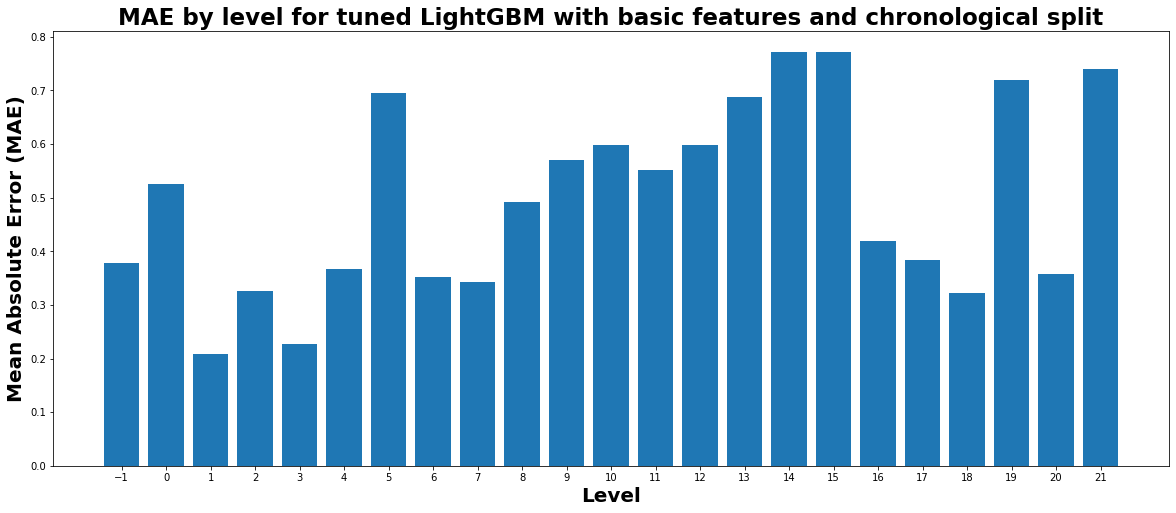

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.69

Round type: 0.5
RMSE: 0.73

Round type: 0.33
RMSE: 0.72

Round type: 0.45
RMSE: 0.70



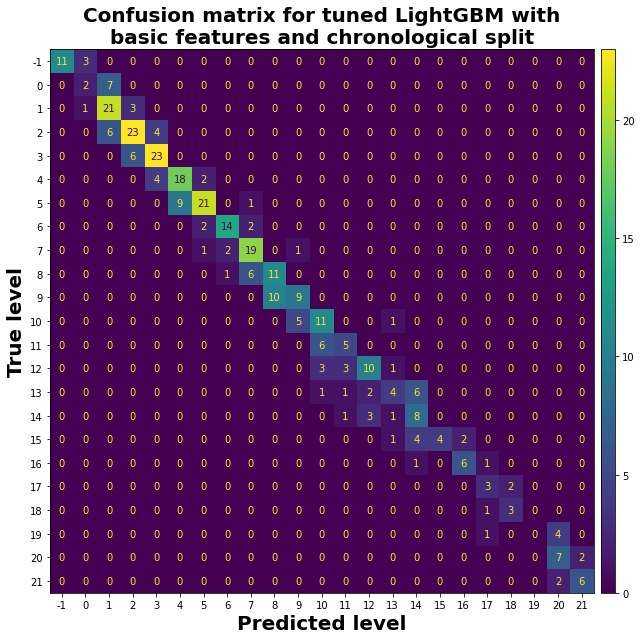

In [29]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nbasic features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l2: 0.238538	valid_0's l1: 0.336785


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.49
MAE: 0.34


In [33]:
results.loc[2] = ["random", "default", "basic", rmse, mae]

###### MAE by level

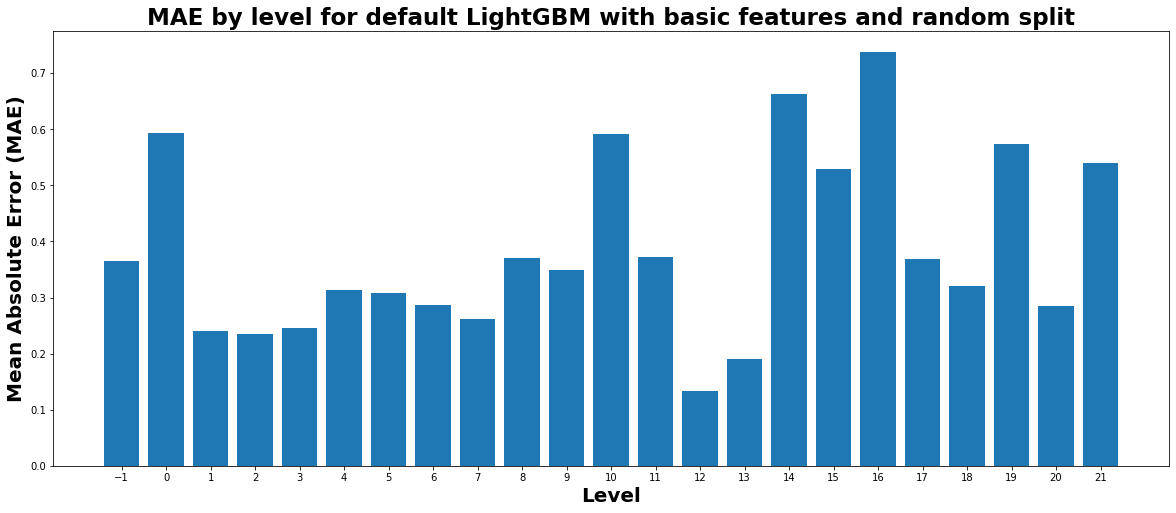

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [35]:
check_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.49

Round type: 0.5
RMSE: 0.51

Round type: 0.33
RMSE: 0.57

Round type: 0.45
RMSE: 0.51



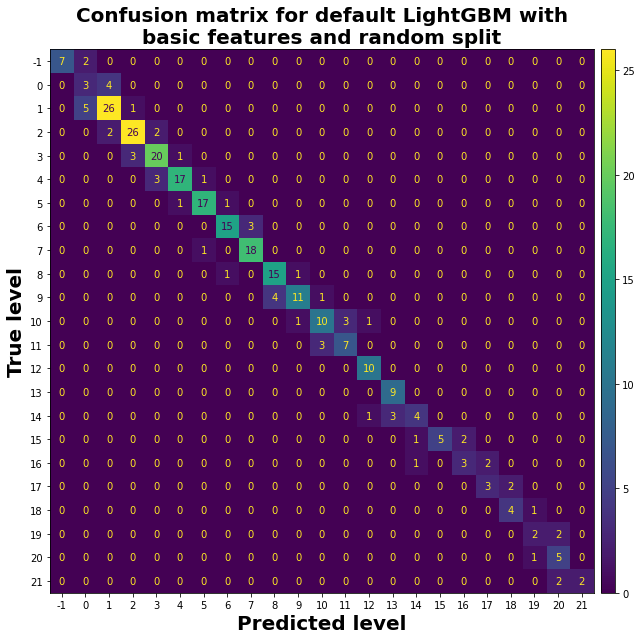

In [36]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with\nbasic features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-09 13:25:47,291] A new study created in memory with name: no-name-f096e146-2efa-40c6-9a1b-e9e8d9ba39ce
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.258042 + 0.0766333
[200]	cv_agg's l2: 0.260551 + 0.0773974


feature_fraction, val_score: 0.256473:  14%|######4                                      | 1/7 [00:02<00:17,  2.92s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.256473 + 0.0774793
[100]	cv_agg's l2: 0.341728 + 0.05249
[200]	cv_agg's l2: 0.312662 + 0.0543104


feature_fraction, val_score: 0.256473:  29%|############8                                | 2/7 [00:05<00:14,  2.95s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.256473 + 0.0774793
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


feature_fraction, val_score: 0.242412:  43%|###################2                         | 3/7 [00:08<00:12,  3.01s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


feature_fraction, val_score: 0.242412:  57%|#########################7                   | 4/7 [00:12<00:09,  3.03s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.278862 + 0.0605807
[200]	cv_agg's l2: 0.268578 + 0.0638728


feature_fraction, val_score: 0.242412:  71%|################################1            | 5/7 [00:15<00:06,  3.01s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.341631 + 0.044839
[200]	cv_agg's l2: 0.313763 + 0.0457461


feature_fraction, val_score: 0.242412:  86%|######################################5      | 6/7 [00:18<00:03,  3.19s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.248169 + 0.0802094
[200]	cv_agg's l2: 0.251245 + 0.0744595


feature_fraction, val_score: 0.242412: 100%|#############################################| 7/7 [00:22<00:00,  3.26s/it]


Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762


num_leaves, val_score: 0.242412:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:   5%|##5                                               | 1/20 [00:03<01:00,  3.21s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  10%|#####                                             | 2/20 [00:06<01:00,  3.38s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  15%|#######5                                          | 3/20 [00:09<00:54,  3.22s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  20%|##########                                        | 4/20 [00:13<00:52,  3.31s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  25%|############5                                     | 5/20 [00:16<00:49,  3.29s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  30%|###############                                   | 6/20 [00:19<00:46,  3.30s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  35%|#################5                                | 7/20 [00:23<00:42,  3.30s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  40%|####################                              | 8/20 [00:26<00:39,  3.28s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  45%|######################5                           | 9/20 [00:29<00:35,  3.26s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.258325 + 0.064121


num_leaves, val_score: 0.242412:  50%|########################5                        | 10/20 [00:30<00:25,  2.54s/it]

[200]	cv_agg's l2: 0.249637 + 0.0613004
Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  55%|##########################9                      | 11/20 [00:33<00:25,  2.81s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  60%|#############################4                   | 12/20 [00:37<00:23,  2.96s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  65%|###############################8                 | 13/20 [00:40<00:21,  3.08s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  70%|##################################3              | 14/20 [00:43<00:18,  3.14s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  75%|####################################7            | 15/20 [00:47<00:15,  3.16s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  80%|#######################################2         | 16/20 [00:50<00:12,  3.18s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  85%|#########################################6       | 17/20 [00:53<00:09,  3.15s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  90%|############################################1    | 18/20 [00:56<00:06,  3.17s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412:  95%|##############################################5  | 19/20 [00:59<00:03,  3.26s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


num_leaves, val_score: 0.242412: 100%|#################################################| 20/20 [01:03<00:00,  3.16s/it]


Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762


bagging, val_score: 0.242412:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.251404 + 0.0514214
[200]	cv_agg's l2: 0.2488 + 0.0466983


bagging, val_score: 0.242412:  10%|#####3                                               | 1/10 [00:03<00:29,  3.26s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.299819 + 0.0601719
[200]	cv_agg's l2: 0.289283 + 0.0561159


bagging, val_score: 0.242412:  20%|##########6                                          | 2/10 [00:04<00:18,  2.34s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.249774 + 0.0477541
[200]	cv_agg's l2: 0.250456 + 0.0463456


bagging, val_score: 0.242412:  30%|###############9                                     | 3/10 [00:08<00:19,  2.74s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.271674 + 0.048051
[200]	cv_agg's l2: 0.266673 + 0.050933


bagging, val_score: 0.242412:  40%|#####################2                               | 4/10 [00:10<00:14,  2.48s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.25302 + 0.0606995
[200]	cv_agg's l2: 0.251244 + 0.0579195


bagging, val_score: 0.242412:  50%|##########################5                          | 5/10 [00:12<00:12,  2.55s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.318152 + 0.0419336
[200]	cv_agg's l2: 0.306396 + 0.0430922


bagging, val_score: 0.242412:  60%|###############################8                     | 6/10 [00:14<00:08,  2.21s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.249702 + 0.0531257
[200]	cv_agg's l2: 0.249511 + 0.0540751


bagging, val_score: 0.242412:  70%|#####################################                | 7/10 [00:16<00:06,  2.29s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.274936 + 0.0455507
[200]	cv_agg's l2: 0.267906 + 0.0490056


bagging, val_score: 0.242412:  80%|##########################################4          | 8/10 [00:19<00:04,  2.22s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.251344 + 0.0435263
[200]	cv_agg's l2: 0.246733 + 0.0391337


bagging, val_score: 0.242412:  90%|###############################################7     | 9/10 [00:21<00:02,  2.41s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.254046 + 0.0454356
[200]	cv_agg's l2: 0.249289 + 0.0385252


bagging, val_score: 0.242412: 100%|####################################################| 10/10 [00:24<00:00,  2.48s/it]


Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762


feature_fraction_stage2, val_score: 0.242412:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


feature_fraction_stage2, val_score: 0.242412:  17%|######3                               | 1/6 [00:03<00:16,  3.26s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


feature_fraction_stage2, val_score: 0.242412:  33%|############6                         | 2/6 [00:06<00:12,  3.13s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.243742 + 0.0487667
[200]	cv_agg's l2: 0.244934 + 0.0478071


feature_fraction_stage2, val_score: 0.242412:  50%|###################                   | 3/6 [00:09<00:09,  3.07s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.248169 + 0.0802094
[200]	cv_agg's l2: 0.251245 + 0.0744595


feature_fraction_stage2, val_score: 0.242412:  67%|#########################3            | 4/6 [00:12<00:06,  3.15s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.248169 + 0.0802094
[200]	cv_agg's l2: 0.251245 + 0.0744595


feature_fraction_stage2, val_score: 0.242412:  83%|###############################6      | 5/6 [00:16<00:03,  3.44s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.248169 + 0.0802094
[200]	cv_agg's l2: 0.251245 + 0.0744595


feature_fraction_stage2, val_score: 0.242412: 100%|######################################| 6/6 [00:19<00:00,  3.29s/it]


Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762


regularization_factors, val_score: 0.242412:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.247078 + 0.0480295
[200]	cv_agg's l2: 0.24795 + 0.0487814


regularization_factors, val_score: 0.242412:   5%|#9                                    | 1/20 [00:05<01:44,  5.52s/it]

Early stopping, best iteration is:
[135]	cv_agg's l2: 0.242412 + 0.0476762
[100]	cv_agg's l2: 0.23561 + 0.0414179
[200]	cv_agg's l2: 0.234667 + 0.0413056


regularization_factors, val_score: 0.233651:  10%|###8                                  | 2/20 [00:08<01:11,  3.96s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.233651 + 0.040121
[100]	cv_agg's l2: 0.234841 + 0.0451691
[200]	cv_agg's l2: 0.235396 + 0.044338


regularization_factors, val_score: 0.233651:  15%|#####7                                | 3/20 [00:10<00:56,  3.30s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.233651 + 0.040121
[100]	cv_agg's l2: 0.237906 + 0.0478349
[200]	cv_agg's l2: 0.238669 + 0.0444976


regularization_factors, val_score: 0.233651:  20%|#######6                              | 4/20 [00:13<00:46,  2.90s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.233651 + 0.040121
[100]	cv_agg's l2: 0.23813 + 0.0478444
[200]	cv_agg's l2: 0.238576 + 0.0472765


regularization_factors, val_score: 0.233651:  25%|#########5                            | 5/20 [00:15<00:40,  2.70s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.233651 + 0.040121
[100]	cv_agg's l2: 0.236802 + 0.0433242
[200]	cv_agg's l2: 0.240511 + 0.0441209


regularization_factors, val_score: 0.233651:  30%|###########4                          | 6/20 [00:17<00:36,  2.59s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.233651 + 0.040121
[100]	cv_agg's l2: 0.24529 + 0.0477122
[200]	cv_agg's l2: 0.246434 + 0.0460719


regularization_factors, val_score: 0.233651:  35%|#############3                        | 7/20 [00:20<00:33,  2.58s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.233651 + 0.040121
[100]	cv_agg's l2: 0.233618 + 0.0432543


regularization_factors, val_score: 0.231174:  35%|#############3                        | 7/20 [00:22<00:33,  2.58s/it]

[200]	cv_agg's l2: 0.233125 + 0.0414824
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476


regularization_factors, val_score: 0.231174:  40%|###############2                      | 8/20 [00:22<00:28,  2.37s/it]

[100]	cv_agg's l2: 0.236921 + 0.045464
[200]	cv_agg's l2: 0.237028 + 0.0440498


regularization_factors, val_score: 0.231174:  45%|#################1                    | 9/20 [00:24<00:24,  2.22s/it]

Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476
[100]	cv_agg's l2: 0.239205 + 0.0459349
[200]	cv_agg's l2: 0.235513 + 0.0438942


regularization_factors, val_score: 0.231174:  50%|##################5                  | 10/20 [00:26<00:21,  2.20s/it]

Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476
[100]	cv_agg's l2: 0.236834 + 0.0448171


regularization_factors, val_score: 0.231174:  50%|##################5                  | 10/20 [00:28<00:21,  2.20s/it]

[200]	cv_agg's l2: 0.235538 + 0.0435962
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476


regularization_factors, val_score: 0.231174:  55%|####################3                | 11/20 [00:28<00:19,  2.13s/it]

[100]	cv_agg's l2: 0.23736 + 0.049108


regularization_factors, val_score: 0.231174:  55%|####################3                | 11/20 [00:30<00:19,  2.13s/it]

[200]	cv_agg's l2: 0.239539 + 0.0497267
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476


regularization_factors, val_score: 0.231174:  60%|######################2              | 12/20 [00:30<00:16,  2.11s/it]

[100]	cv_agg's l2: 0.237724 + 0.043365
[200]	cv_agg's l2: 0.238079 + 0.0435999


regularization_factors, val_score: 0.231174:  65%|########################             | 13/20 [00:32<00:14,  2.04s/it]

Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476
[100]	cv_agg's l2: 0.244886 + 0.0463218


regularization_factors, val_score: 0.231174:  70%|#########################9           | 14/20 [00:34<00:12,  2.03s/it]

[200]	cv_agg's l2: 0.244001 + 0.050471
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476
[100]	cv_agg's l2: 0.241502 + 0.0467056


regularization_factors, val_score: 0.231174:  75%|###########################7         | 15/20 [00:36<00:10,  2.02s/it]

[200]	cv_agg's l2: 0.245827 + 0.0478947
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476


[I 2023-11-09 13:28:34,328] Trial 57 finished with value: 0.24274987617115734 and parameters: {'lambda_l1': 5.598732046003246e-07, 'lambda_l2': 0.13875060773124806}. Best is trial 50 with value: 0.23117353445821967.
regularization_factors, val_score: 0.231174:  75%|###########################7         | 15/20 [00:36<00:10,  2.02s/it]

[100]	cv_agg's l2: 0.251603 + 0.0497443


regularization_factors, val_score: 0.231174:  75%|###########################7         | 15/20 [00:38<00:10,  2.02s/it]

[200]	cv_agg's l2: 0.250622 + 0.048399
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476


regularization_factors, val_score: 0.231174:  80%|#############################6       | 16/20 [00:38<00:08,  2.13s/it]

[100]	cv_agg's l2: 0.247185 + 0.0533315


regularization_factors, val_score: 0.231174:  80%|#############################6       | 16/20 [00:40<00:08,  2.13s/it]

[200]	cv_agg's l2: 0.247815 + 0.0515381
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476


regularization_factors, val_score: 0.231174:  85%|###############################4     | 17/20 [00:40<00:06,  2.09s/it]

[100]	cv_agg's l2: 0.246228 + 0.0457957


regularization_factors, val_score: 0.231174:  90%|#################################3   | 18/20 [00:42<00:04,  2.05s/it]

[200]	cv_agg's l2: 0.244915 + 0.043224
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476
[100]	cv_agg's l2: 0.236394 + 0.0465497


regularization_factors, val_score: 0.231174:  95%|###################################1 | 19/20 [00:44<00:02,  2.04s/it][I 2023-11-09 13:28:42,671] Trial 61 finished with value: 0.23485622218864796 and parameters: {'lambda_l1': 1.1479861566657147e-08, 'lambda_l2': 9.929048427778136}. Best is trial 50 with value: 0.23117353445821967.


[200]	cv_agg's l2: 0.234898 + 0.0430834
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476


regularization_factors, val_score: 0.231174:  95%|###################################1 | 19/20 [00:44<00:02,  2.04s/it]

[100]	cv_agg's l2: 0.236782 + 0.0461013


regularization_factors, val_score: 0.231174: 100%|#####################################| 20/20 [00:46<00:00,  2.33s/it]


[200]	cv_agg's l2: 0.236429 + 0.0446852
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.231174 + 0.0414476


min_data_in_leaf, val_score: 0.231174:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.22117 + 0.0434738
[200]	cv_agg's l2: 0.221499 + 0.0427449


min_data_in_leaf, val_score: 0.218880:  20%|#########                                    | 1/5 [00:02<00:09,  2.36s/it]

Early stopping, best iteration is:
[119]	cv_agg's l2: 0.21888 + 0.0421221
[100]	cv_agg's l2: 0.332807 + 0.0718899


min_data_in_leaf, val_score: 0.218880:  40%|##################                           | 2/5 [00:03<00:04,  1.61s/it]

[200]	cv_agg's l2: 0.326246 + 0.0665625
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.21888 + 0.0421221
[100]	cv_agg's l2: 0.220721 + 0.0452626


min_data_in_leaf, val_score: 0.218880:  40%|##################                           | 2/5 [00:05<00:04,  1.61s/it]

[200]	cv_agg's l2: 0.22111 + 0.0436904
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.21888 + 0.0421221


min_data_in_leaf, val_score: 0.218880:  60%|###########################                  | 3/5 [00:05<00:03,  1.91s/it]

[100]	cv_agg's l2: 0.258455 + 0.0604987


min_data_in_leaf, val_score: 0.218880:  80%|####################################         | 4/5 [00:07<00:01,  1.86s/it]

[200]	cv_agg's l2: 0.258252 + 0.057574
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.21888 + 0.0421221
[100]	cv_agg's l2: 0.812226 + 0.06314


min_data_in_leaf, val_score: 0.218880: 100%|#############################################| 5/5 [00:08<00:00,  1.63s/it]

[200]	cv_agg's l2: 0.789943 + 0.0712363
Early stopping, best iteration is:
[119]	cv_agg's l2: 0.21888 + 0.0421221


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.21887970685446007
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.1121154373158193e-08
    lambda_l2: 8.090254380689329
    num_leaves: 31
    feature_fraction: 0.8
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.51
MAE test: 0.34



In [41]:
results.loc[3] = ["random", "Optuna", "basic", rmse, mae]

###### MAE by level

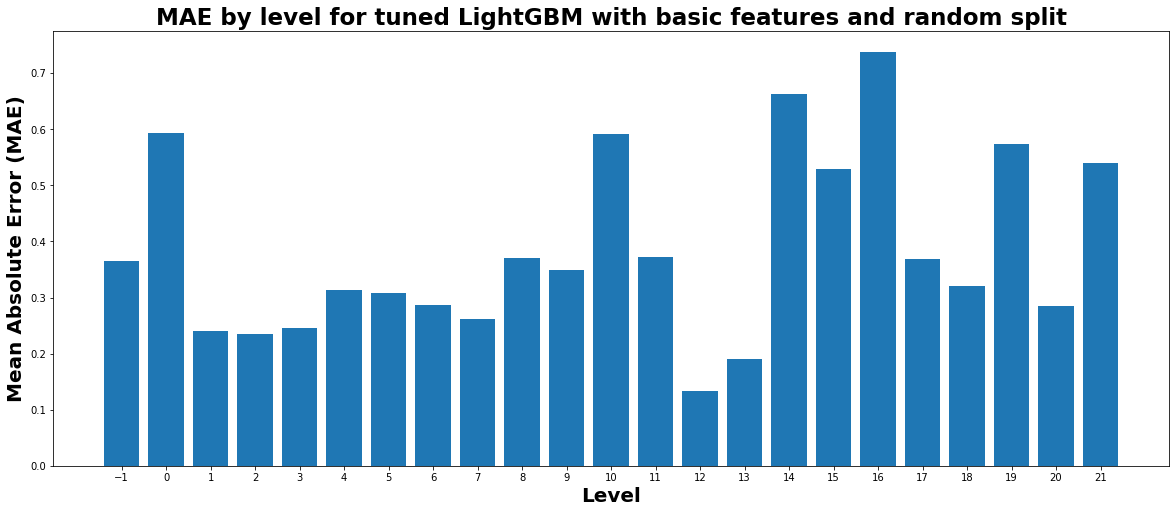

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.34

Round type: 0.5
RMSE: 0.39

Round type: 0.33
RMSE: 0.36

Round type: 0.45
RMSE: 0.37



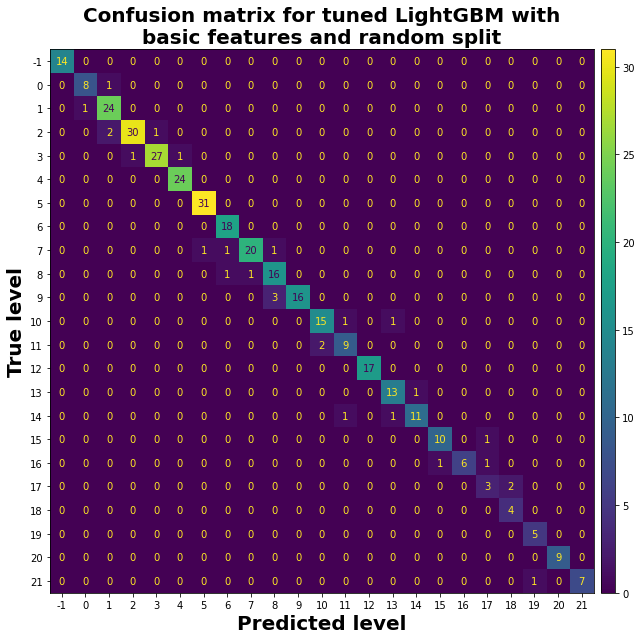

In [44]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nbasic features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,basic,0.669004,0.467604
1,chronological,Optuna,basic,0.687156,0.485704
2,random,default,basic,0.488404,0.336785
3,random,Optuna,basic,0.512964,0.338632


In [46]:
from training.results import plot_summary

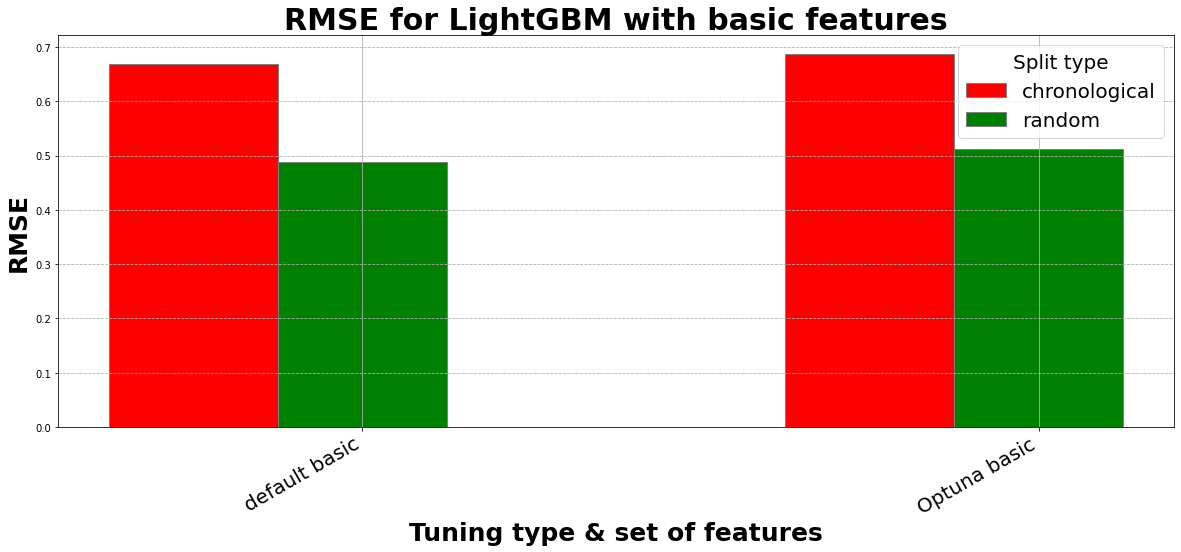

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

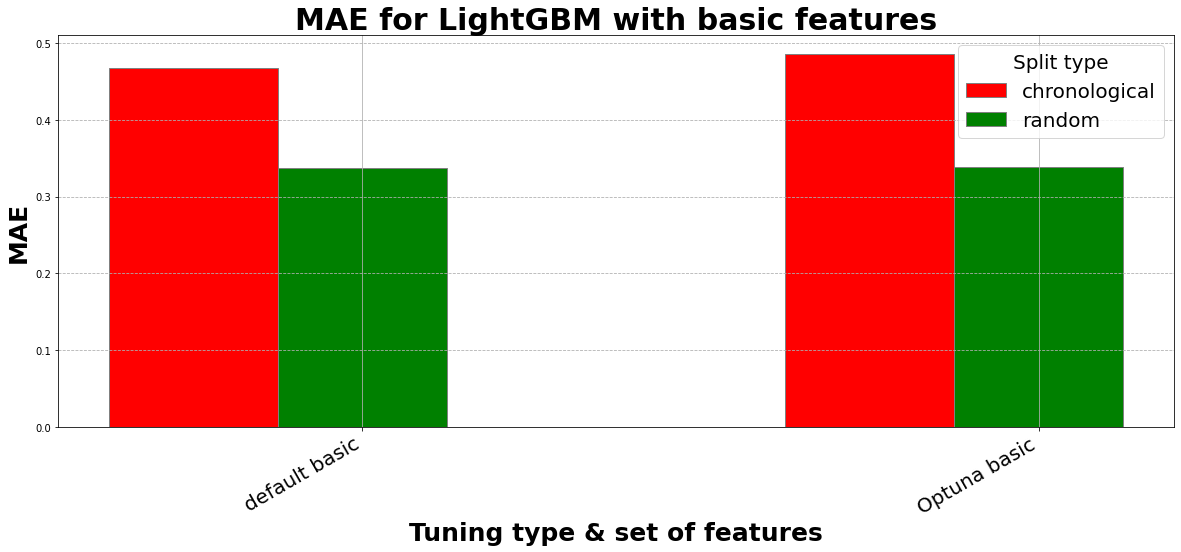

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [49]:
results.to_json("./lightgbm_basic_results.json", indent=2)